# 對 PTT 特斯拉 公司進行情緒分析

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- matplotlib: 繪圖工具。
- wordcloud: 繪製文字雲工具。
- jieba: 中文斷詞工具。

## 本機使用套間
請先於環境中使用 pip install

In [63]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as font_manager
from wordcloud import WordCloud 
import jieba

## colab 使用套件

In [64]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


## 2. 資料前處理
如 week3 所示  
使用「吃到飽」作為關鍵字，從工作流程系統中將 ptt 資料下載下來

### 2.1 基本資料介紹
- 資料來源: 工作流程蒐集 PTT 股票版 Stock 2023-03-20 ~ 2024-03-20 所有文章

In [65]:
df = pd.read_csv("data/ppt_tesla.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,xross,car,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""maniaque"", ""...",99.36.164.58,2023-01-02 01:04:34,ptt
1,2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,jpopo0543,car,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""r7698"", ""cmt...",114.46.142.179,2023-01-02 01:04:40,ptt
2,3,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,2023-01-02,weiflower520,car,原文連結：\nhttps://star.setn.com/news/1232578?utm_...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""tyrande"", ""c...",27.247.164.57,2023-01-03 01:04:36,ptt
3,4,https://www.ptt.cc/bbs/car/M.1672653666.A.3F2....,[討論]是不是真的有些四輪覺得自己是大爺？,2023-01-02,torrest,car,如題 本身開特斯拉\n\n最近出門覺得找車位很煩都騎家裡超舊機車\n\n基本上在路上有機車道...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""kutkin"", ""cm...",27.242.163.97,2023-01-03 01:04:36,ptt
4,5,https://www.ptt.cc/bbs/car/M.1672658487.A.A66....,[新聞]2022美國汽車召回排名揭曉第一名超過8,2023-01-02,SakuraHana,car,原文連結：\nhttps://auto.ltn.com.tw/news/21866/3\n原...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""luke2007"", ""...",220.129.145.135,2023-01-03 01:04:36,ptt


### 2.2資料清理

In [66]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦是官網特斯拉二手車。比很多第三方平台都便宜
1,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,各位前輩好 想買中古特斯拉里程約5萬上下的。擔心電池久了會掉電越充越少電 里程數越少開了10...
2,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,2023-01-02,原文連結：\nhttps://star.setn.com/news/1232578?utm_...,原文連結： 一排噓聲。。劉偉健Toyz：「法官在看，特斯拉耶，人工智能OK，雙手放開雙腳放開...
3,https://www.ptt.cc/bbs/car/M.1672653666.A.3F2....,[討論]是不是真的有些四輪覺得自己是大爺？,2023-01-02,如題 本身開特斯拉\n\n最近出門覺得找車位很煩都騎家裡超舊機車\n\n基本上在路上有機車道...,如題 本身開特斯拉。最近出門覺得找車位很煩都騎家裡超舊機車。基本上在路上有機車道騎機車道。沒...
4,https://www.ptt.cc/bbs/car/M.1672658487.A.A66....,[新聞]2022美國汽車召回排名揭曉第一名超過8,2023-01-02,原文連結：\nhttps://auto.ltn.com.tw/news/21866/3\n原...,原文連結： 美國汽車召回排名揭曉 第一名超過 800 萬輛車進廠處理。2022 結束迎來 2...
...,...,...,...,...,...
1581,https://www.ptt.cc/bbs/car/M.1714444417.A.274....,Re:[新聞]特斯拉「全新入門電動車」準備量產！80,2024-04-30,哪有到1.5倍，1.5那種是油車\n電動車現在沒有貨物稅\nhttps://i.imgur....,哪有到1.5倍，1.5那種是油車電動車現在沒有貨物稅 新的便宜款真的維持在25000美金內。...
1582,https://www.ptt.cc/bbs/car/M.1714451073.A.EE8....,Re:[分享]TucsonL撞緩撞車啦,2024-04-30,要系統性的改善緩撞車被ACC\n撞的問題！\n\n建議交通部學習美國跟特斯拉的案件\n作法，...,要系統性的改善緩撞車被ACC撞的問題！。建議交通部學習美國跟特斯拉的案件作法，以後強制要求各...
1583,https://www.ptt.cc/bbs/car/M.1714470321.A.C60....,Re:[新聞]銷售降溫賓士上季獲利銳減逾三成、福斯,2024-04-30,****:都轉單到特斯拉了 誰跟你買雙B\n(不針對ID，本板及M01有多位朋友同想法)\n...,****:都轉單到特斯拉了 誰跟你買雙B(不針對ID，本板及M01有多位朋友同想法)。都20...
1584,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...,最近物色下一台車。原本抓250左右。上週去看了特斯拉 MODEL Y LONG RANGE。...


斷句

In [67]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦是官網特斯拉二手車
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,比很多第三方平台都便宜
2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,各位前輩好 想買中古特斯拉里程約5萬上下的
3,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,擔心電池久了會掉電越充越少電 里程數越少開了10年後車子變成3c垃圾里程連100公里都不到
4,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,另外請問電動車建議買新的還是中古的就好因為有載寵物 就算之後賣中古應該也沒人收但是想要負擔輕...
...,...,...,...,...,...
39017,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...,請問我的用車情境 有更好的選擇嗎
39018,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...,
39019,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,RX吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買Y LR
39020,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,不過你預算到250有喜歡飆車的話


In [68]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')

Building prefix dict from d:\114 NSYSU MIS\SMA 特斯拉\dict\dict.txt ...
Loading model from cache C:\Users\hands\AppData\Local\Temp\jieba.u47c81f24884f39d5ea1dad8cbdecc8d2.cache
Loading model cost 0.739 seconds.
Prefix dict has been built successfully.


In [69]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+|[\d]', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦是官網特斯拉二手車
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,比很多第三方平台都便宜
2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,各位前輩好 想買中古特斯拉里程約萬上下的
3,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,擔心電池久了會掉電越充越少電 里程數越少開了年後車子變成c垃圾里程連公里都不到
4,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,另外請問電動車建議買新的還是中古的就好因為有載寵物 就算之後賣中古應該也沒人收但是想要負擔輕...
...,...,...,...,...,...
39016,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...,爬文版上好像有更優惠的菜單
39017,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...,請問我的用車情境 有更好的選擇嗎
39019,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,RX吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買Y LR
39020,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,不過你預算到有喜歡飆車的話


### 2.3 文章斷詞

In [70]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,官網
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,特斯拉
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,二手車
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,很多
...,...,...,...,...,...
39021,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,可以
39021,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,Sent
39021,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,fromPttXon
39021,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,my


移除停用字

In [71]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
stopwords_manual = ["原文", "標題", "今年", "來源", "公司", "評論", "署名", "內容時間", "現在", "連結", "目前", "股票",
                    "股價", "台積電", "台積", "台股", "台灣", "台灣股市", "台灣股票", "台灣股價", "台灣股票市場",
                    "台灣股市", "內容", "評論", "文章", "內文", "記者", "指出", "心得", "來源", "市場", "表示", "去年",
                    "預期", "億元", "TW", "持續", "未來", "產業", "券增", "排行", "證券", "今天", "報導", "分類",
                    "網址", "時間", "客戶", "認為", "討論", "張數", "相關", "影響", "機制", "億美元", "美元", "企業",
                    "金額", "資料", "發布", "格式", "投資","馬斯克", "伊隆", "伊隆馬斯克", "特斯拉", "投資"]
stopwords.extend(stopwords_manual)

In [72]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,官網
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,二手車
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,三方
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,平台
...,...,...,...,...,...
39021,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,LR
39021,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,Sent
39021,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,fromPttXon
39021,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,my


## 3. Lexicon-based 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
>  就英文版的LIWC2007來說，目前包含了64個定義類別。這些類別包括基本的語文向度類別，例如： 22個語文特性類別（如，代名詞、冠詞等百分比）、3個副語言學（paralinguistic）類別（如應和詞、停頓詞等）。除了已經有具有明確定義的語文類別之外，LIWC也另外包含了32個心理特性類別（如，情感詞、認知詞等）、7個個人化類別（如工作、休閒活動等）。再加上程式自動計算出的6個一般描述性類別（總詞數、每句詞數等）以及12個標點符號類別（如句點、逗點等），總計可輸出80個字詞類別。
- https://cliwc.weebly.com/liwc20073542220856.html 
- https://cliwc.weebly.com/35422208563900621029200131228933521259913549826126.html

In [73]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [74]:
liwc_dict['sentiments'].describe()

count       4715
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

```merge function 介紹```
https://www.delftstack.com/zh-tw/howto/python-pandas/merge-dataframes-on-index-in-pandas/

In [75]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦,affect
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦,negative
2,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,官網,NaN
3,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,二手車,NaN
4,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,三方,NaN
...,...,...,...,...,...,...
176460,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,2024-04-30,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,LR,NaN
176461,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,2024-04-30,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,Sent,NaN
176462,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,2024-04-30,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,fromPttXon,NaN
176463,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,2024-04-30,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,my,NaN


### 3.3 正負向情緒詞彙頻率折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

```情緒分析指標```
在情緒分析中，我們會以不同的指標來看情緒的好壞，其中常見的包含：
1. **情感詞彙頻率**： 使用情感詞彙列表，其中包含正向和負向情感的詞彙。將文本中的詞與該列表進行匹配，計算正向和負向詞彙的出現次數，從而判斷整體情感傾向。
2. **情感詞彙比例**：不同於單純的計算頻率，比例是某種情緒（例如：正向）佔所有情緒詞中的幾分之幾。這種方法可以避免某一天文章數特別多（詞頻也會隨之變多）而影響情緒的判斷。
2. **情感詞彙分數**： 給每個情感詞彙分配一個權重或分數，然後計算文本中所有情感詞的總分。這種方法允許區分不同情感詞的影響力，進一步細化情感分析的結果。

我們先以最基本的詞頻來計算

```groupby function 介紹```https://zhuanlan.zhihu.com/p/101284491

In [76]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
3,2023-01-01,negative,4
6,2023-01-02,negative,8
7,2023-01-02,positive,3
10,2023-01-03,negative,3
11,2023-01-03,positive,9
...,...,...,...
1884,2024-04-28,positive,21
1888,2024-04-29,negative,4
1889,2024-04-29,positive,7
1893,2024-04-30,negative,27


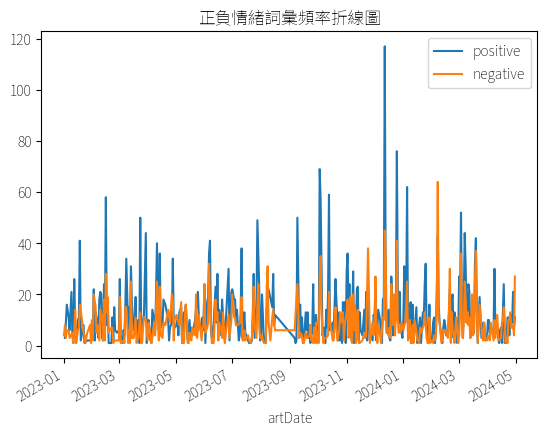

In [77]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖")  # 記得加上才能顯示中文
plt.show()

```Moving average```
- rolling average（滾動平均）是一種將時間序列數據平滑化的技術，有助於去除數據中的噪聲，使趨勢更加明顯，同時仍然保留一定的時間特徵。
- 在情緒分析中，特別是當你有一系列時間序列的情緒數據時，使用滾動平均有助於平滑數據，使情緒趨勢更加清晰。
    1. **去除瞬間噪聲**： 情緒數據可能受到瞬間事件或噪聲的影響，例如突發的大量評論或新聞。滾動平均有助於平滑這些突變，使你更容易觀察到整體趨勢。
    2. **強調長期趨勢**： 滾動平均有助於強調長期情緒趨勢，而不受短期波動的干擾。這對於觀察情緒的漸變和長期變化非常有用。


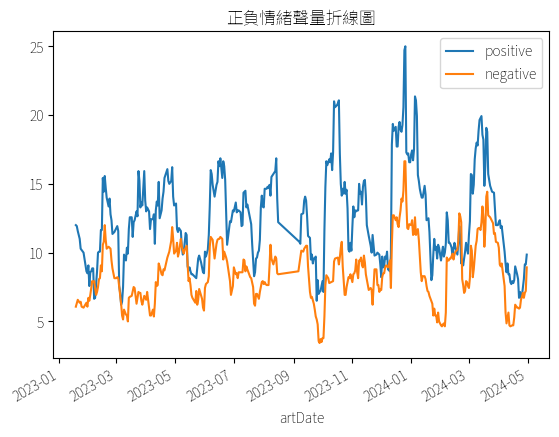

In [78]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖")  # 記得加上才能顯示中文
plt.show()

畫出每天的情緒總分數，可以看到正面的詞出現頻率幾乎每天都超過負面，是個氣氛和諧的討論版。

```詞頻缺點```

如果某一天有什麼事件發生而導致正負向詞頻數隨之飆高，在趨勢圖看來可能會認為該區間的正負向情緒較為顯著，但也有可能是因為總體情緒詞彙本來就比較多而導致的。

以比例的方式來看，我們可以觀察到某個情緒詞在總體情緒詞彙中所佔的比例，就算某一天文章數相較多，也不會影響到比例的呈現。

### 3.4 正負向情緒詞彙比例折線圖圖

```lambda```函式是一種匿名函式，包含以下幾點特性：

+ 不需要定義函式名稱
+ 只能有一行運算式
+ 執行完後會自動回傳結果，不需要return   

因此```lambda```適合在該函式只有單行運算式且不會被重複呼叫時使用

參考網址：   
[Python Lambda](https://www.w3schools.com/python/python_lambda.asp)   
[Lambda — Python 重要語法技巧](https://medium.com/johnliu-的軟體工程思維/lambda-python-重要語法技巧-27c467ddfa16)

In [79]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
3,2023-01-01,negative,4,1.000000
6,2023-01-02,negative,8,0.727273
7,2023-01-02,positive,3,0.272727
10,2023-01-03,negative,3,0.250000
11,2023-01-03,positive,9,0.750000
...,...,...,...,...
1884,2024-04-28,positive,21,0.724138
1888,2024-04-29,negative,4,0.363636
1889,2024-04-29,positive,7,0.636364
1893,2024-04-30,negative,27,0.710526


In [80]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

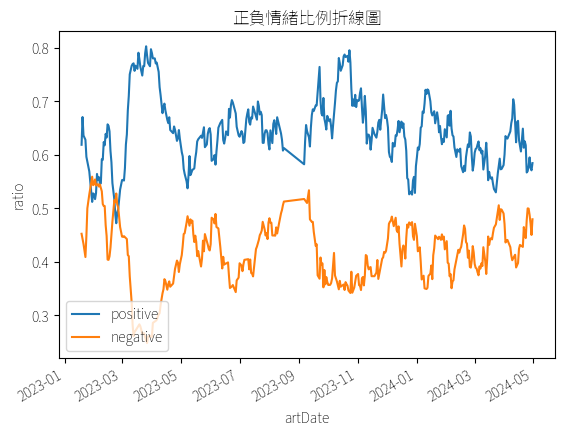

In [81]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

### 3.5 正負向情緒分數折線圖

In [82]:
sentiment_count

,artDate,sentiments,size,ratio
3,2023-01-01,negative,4,1.000000
6,2023-01-02,negative,8,0.727273
7,2023-01-02,positive,3,0.272727
10,2023-01-03,negative,3,0.250000
11,2023-01-03,positive,9,0.750000
...,...,...,...,...
1884,2024-04-28,positive,21,0.724138
1888,2024-04-29,negative,4,0.363636
1889,2024-04-29,positive,7,0.636364
1893,2024-04-30,negative,27,0.710526


In [83]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,negative,positive
0,2023-01-01,4.0,0.0
1,2023-01-02,8.0,3.0
2,2023-01-03,3.0,9.0
3,2023-01-04,6.0,16.0
4,2023-01-06,6.0,11.0


In [84]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2023-01-01,4.0,0.0,-4.0
1,2023-01-02,8.0,3.0,-5.0
2,2023-01-03,3.0,9.0,6.0
3,2023-01-04,6.0,16.0,10.0
4,2023-01-06,6.0,11.0,5.0


Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

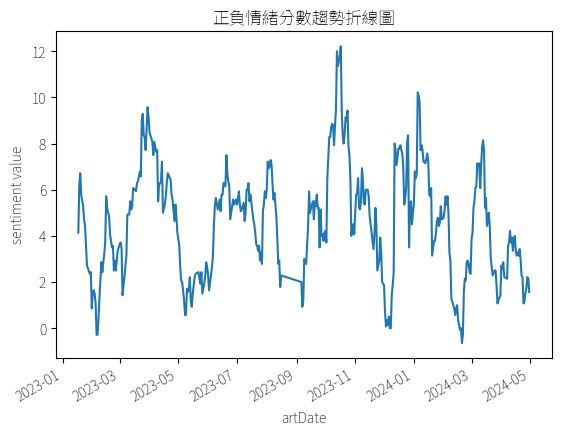

In [85]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

### 3.6 文章為單位的情緒分析

In [86]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

,artUrl,sentiments,size
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,affect,1
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,negative,1
2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,affect,3
3,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,anger,1
4,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,anx,1
...,...,...,...
4313,https://www.ptt.cc/bbs/car/M.1714470321.A.C60....,positive,3
4314,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,affect,4
4315,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,positive,4
4316,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,affect,1


In [87]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,1.0,0.0,0.0,1.0,0.0,0.0
1,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,3.0,1.0,1.0,3.0,0.0,0.0
2,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,10.0,1.0,0.0,7.0,3.0,0.0
3,https://www.ptt.cc/bbs/car/M.1672653666.A.3F2....,1.0,0.0,0.0,0.0,0.0,0.0
4,https://www.ptt.cc/bbs/car/M.1672658487.A.A66....,1.0,0.0,0.0,1.0,0.0,0.0


In [88]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,1.0,0.0,0.0,1.0,0.0,0.0,-1.0
1,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,3.0,1.0,1.0,3.0,0.0,0.0,-3.0
2,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,10.0,1.0,0.0,7.0,3.0,0.0,-4.0
3,https://www.ptt.cc/bbs/car/M.1672653666.A.3F2....,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,https://www.ptt.cc/bbs/car/M.1672658487.A.A66....,1.0,0.0,0.0,1.0,0.0,0.0,-1.0


In [89]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,1.0,0.0,0.0,1.0,0.0,0.0,-1.0,負向
1,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,3.0,1.0,1.0,3.0,0.0,0.0,-3.0,負向
2,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,10.0,1.0,0.0,7.0,3.0,0.0,-4.0,負向
3,https://www.ptt.cc/bbs/car/M.1672653666.A.3F2....,1.0,0.0,0.0,0.0,0.0,0.0,0.0,負向
4,https://www.ptt.cc/bbs/car/M.1672658487.A.A66....,1.0,0.0,0.0,1.0,0.0,0.0,-1.0,負向
...,...,...,...,...,...,...,...,...,...
1266,https://www.ptt.cc/bbs/car/M.1714443909.A.8B7....,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
1267,https://www.ptt.cc/bbs/car/M.1714451073.A.EE8....,2.0,0.0,0.0,1.0,1.0,0.0,0.0,負向
1268,https://www.ptt.cc/bbs/car/M.1714470321.A.C60....,15.0,3.0,1.0,24.0,3.0,0.0,-21.0,負向
1269,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,4.0,0.0,0.0,0.0,4.0,0.0,4.0,正向


In [90]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentiment_class
0,1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,xross,car,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""maniaque"", ""...",99.36.164.58,2023-01-02 01:04:34,ptt,負向
1,2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,jpopo0543,car,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""r7698"", ""cmt...",114.46.142.179,2023-01-02 01:04:40,ptt,負向
2,3,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,2023-01-02,weiflower520,car,原文連結：\nhttps://star.setn.com/news/1232578?utm_...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""tyrande"", ""c...",27.247.164.57,2023-01-03 01:04:36,ptt,負向
3,4,https://www.ptt.cc/bbs/car/M.1672653666.A.3F2....,[討論]是不是真的有些四輪覺得自己是大爺？,2023-01-02,torrest,car,如題 本身開特斯拉\n\n最近出門覺得找車位很煩都騎家裡超舊機車\n\n基本上在路上有機車道...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""kutkin"", ""cm...",27.242.163.97,2023-01-03 01:04:36,ptt,負向
4,5,https://www.ptt.cc/bbs/car/M.1672658487.A.A66....,[新聞]2022美國汽車召回排名揭曉第一名超過8,2023-01-02,SakuraHana,car,原文連結：\nhttps://auto.ltn.com.tw/news/21866/3\n原...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""luke2007"", ""...",220.129.145.135,2023-01-03 01:04:36,ptt,負向
...,...,...,...,...,...,...,...,...,...,...,...,...
1581,1582,https://www.ptt.cc/bbs/car/M.1714444417.A.274....,Re:[新聞]特斯拉「全新入門電動車」準備量產！80,2024-04-30,QuentinHu,car,哪有到1.5倍，1.5那種是油車\n電動車現在沒有貨物稅\nhttps://i.imgur....,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""sted0101"", ""...",175.98.154.254,2024-05-01 01:05:53,ptt,NaN
1582,1583,https://www.ptt.cc/bbs/car/M.1714451073.A.EE8....,Re:[分享]TucsonL撞緩撞車啦,2024-04-30,H2,car,要系統性的改善緩撞車被ACC\n撞的問題！\n\n建議交通部學習美國跟特斯拉的案件\n作法，...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ilovedirk41""...",61.66.151.73,2024-05-01 01:05:53,ptt,負向
1583,1584,https://www.ptt.cc/bbs/car/M.1714470321.A.C60....,Re:[新聞]銷售降溫賓士上季獲利銳減逾三成、福斯,2024-04-30,orzzz,car,****:都轉單到特斯拉了 誰跟你買雙B\n(不針對ID，本板及M01有多位朋友同想法)\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""sted0101"", ""...",1.200.2.37,2024-05-01 01:05:57,ptt,負向
1584,1585,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,David989,car,最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""birdane32"", ...",218.161.8.52,2024-05-01 01:05:57,ptt,正向


In [91]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2023-01-01,負向,2
1,2023-01-02,負向,3
2,2023-01-03,正向,1
3,2023-01-03,負向,1
4,2023-01-04,正向,2
...,...,...,...
623,2024-04-28,正向,2
624,2024-04-29,正向,2
625,2024-04-29,負向,1
626,2024-04-30,正向,3


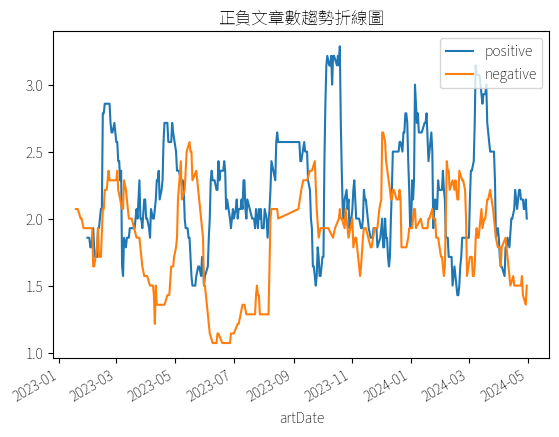

In [92]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖")  # 記得加上才能顯示中文
plt.show()

某些時間段落 相差甚大，或 負面高於正面 

### 3.7 情緒代表字

In [93]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
536,安全,positive,228
535,安全,affect,228
391,喜歡,affect,172
392,喜歡,positive,172
1656,遇到,affect,157
...,...,...,...
159,值錢,affect,1
156,倒霉,negative,1
1385,笨拙,affect,1
1386,笨拙,negative,1


In [94]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
536,安全,positive,228
392,喜歡,positive,172
244,分享,positive,155
1030,朋友,positive,135
600,希望,positive,132
66,不錯,positive,127
1393,簡單,positive,106
560,容易,positive,104
1601,豪華,positive,92
1538,解決,positive,87


In [95]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
1721,降低,negative,116
86,事故,negative,115
447,壓力,negative,98
1442,缺點,negative,96
908,控制,negative,92
1534,衰退,negative,82
943,擔心,negative,64
421,嚴重,negative,63
1821,麻煩,negative,58
1528,虧損,negative,56


C:\Users\hands\AppData\Local\Temp\ipykernel_2064\2349181045.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"])
C:\Users\hands\AppData\Local\Temp\ipykernel_2064\2349181045.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

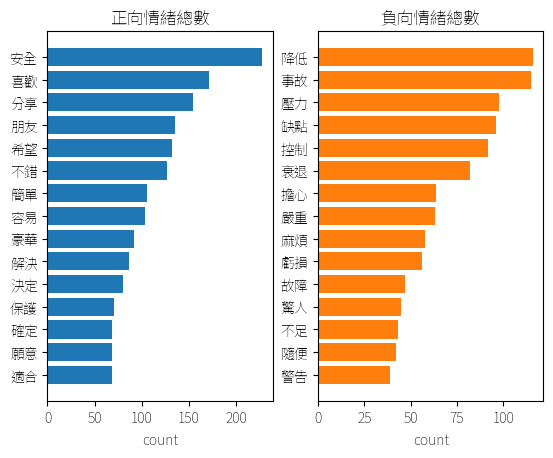

In [96]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

#### 檢查情緒詞是否符合本文本

In [97]:
filtered_df = sent_df[sent_df['sentence'].str.contains('挑戰', na=False)]
filtered_df.head()

,artUrl,artTitle,artDate,artContent,sentence
1564,https://www.ptt.cc/bbs/car/M.1674199727.A.B71....,[新聞]ToyotabZ4X出師不利 豐田想提高電動車,2023-01-20,Toyota bZ4X出師不利 豐田想提高電動車銷量遇上「前所未見」的挑戰\n經濟日報 編譯...,Toyota bZX出師不利 豐田想提高電動車銷量遇上前所未見的挑戰經濟日報 編譯季晶晶綜合外電
1567,https://www.ptt.cc/bbs/car/M.1674199727.A.B71....,[新聞]ToyotabZ4X出師不利 豐田想提高電動車,2023-01-20,Toyota bZ4X出師不利 豐田想提高電動車銷量遇上「前所未見」的挑戰\n經濟日報 編譯...,全球最大車廠提升電動車銷售的努力正面臨前所未見的挑戰
1832,https://www.ptt.cc/bbs/car/M.1675172419.A.BBD....,[新聞]和台灣市場大不同2022年各國熱賣車款出爐,2023-01-31,原文連結：\nhttps://autos.udn.com/autos/story/7826/...,考慮到全球所面臨的挑戰
3415,https://www.ptt.cc/bbs/car/M.1676449035.A.98F....,[新聞]2023年全球電動車電池裝機量將達749GWh,2023-02-15,原文連結：\nhttps://bit.ly/3Eaxwxn\n原文內容：\n根據韓國研究機構...,未來也將面臨挑戰
3769,https://www.ptt.cc/bbs/car/M.1676623286.A.8E6....,[新聞]曾被認為可挑戰特斯拉的Rivian改變戰略,2023-02-17,曾被認為可挑戰特斯拉的Rivian，改變戰略，往電動自行車市場前進\n\n原文連結：\nht...,曾被認為可挑戰特斯拉的Rivian


In [98]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

Toyota bZX出師不利　豐田想提高電動車銷量遇上前所未見的挑戰經濟日報 編譯季晶晶綜合外電
全球最大車廠提升電動車銷售的努力正面臨前所未見的挑戰
考慮到全球所面臨的挑戰
未來也將面臨挑戰
曾被認為可挑戰特斯拉的Rivian
這份榜單凸顯了電動車發展所面臨的挑戰
我們正在挑戰汽車製造商
並分為領導者競爭者挑戰者和追隨者等  個等級
儘管市場挑戰重重
以及外部競爭因素可能對於其達成目標將帶來挑戰
加速回應未來的種種挑戰
但這並非中國本土製造商面臨的唯一挑戰
躋身特斯拉最具競爭力中國挑戰者之列的理想汽車蔚來集團小鵬汽車尚未實現持續盈利
都是很大的挑戰
如何解決鋰電池供應將是下一個煩惱的挑戰
還有挑戰性
電池企業的地位將受到挑戰
以支持歐洲應對運輸能源轉型的挑戰
Deloitte認為下一個挑戰將是確保自動駕駛汽車的網路安全
特斯拉預定年底挑戰銷售  萬輛車
也是巨大挑戰
電車挑戰縱切是不是有點硬
這對所有汽車製造商來說將是一項重大挑戰
美國電動車市場正面臨庫存過剩降價以及難以提高市場佔有率等挑戰
美國的電動車市場正面臨著與庫存過剩降價和難以提高市場份額相關的挑戰
早在去年底一場Taco Bell技術挑戰賽中
這輛車就是為了挑戰Model S Plaid而來
德國正面臨挑戰
Tesla大概只有在中國碰到比較嚴重的挑戰
面臨的挑戰是相同的
整個美國汽車產業的未來看起來充滿挑戰
而Rivian則面臨製造品質和氣候控制功能等方面的挑戰
電動車電池產業的發展正面臨著一些挑戰
提供美國聯邦大量資金強化充電網路以及解決其他挑戰
電動車電池產業的發展正面臨著一些挑戰
宏觀經濟挑戰將進一步抑制需求
建立策略合作夥伴關係並投資於直接應對關鍵挑戰的新創新將是原始設備製造商在未來一年取得成功的途徑
宏觀經濟挑戰將抑制需求
為了應對這些挑戰
敝國的納智捷N上半年先挾著近萬訂單要挑戰特斯拉銷售王寶座
以及可能會遇到什麼挑戰
年電動車市場將面臨一些挑戰
舒適度這條胎很安靜安靜到我能聽到避震運作的聲音只是目前寧靜度最好是普利司通Tev有其他胎想挑戰可以私下聯絡我
原文連結 Kern駕駛全新Taycan原型車以分秒完成紐柏林北環賽道單圈挑戰
車廠與買主均面臨新挑戰
出頭萬確實有機會挑戰市場至於中國品牌電動車
提醒消費者電動車在極端氣候下仍有挑戰
可能是二寶出生前最大的挑戰
電池更換在美國面臨的前景比在

#### 重新計算情緒

控制、驚人、不足、隨便、警告

In [99]:
# 設定要移除的字詞列表
words_to_remove = [ '控制', '驚人', '不足', '隨便', '警告']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict_revise,
                              how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦,affect
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦,negative
2,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,官網,NaN
3,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,二手車,NaN
4,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,三方,NaN


C:\Users\hands\AppData\Local\Temp\ipykernel_2064\1871799801.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"])
C:\Users\hands\AppData\Local\Temp\ipykernel_2064\1871799801.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

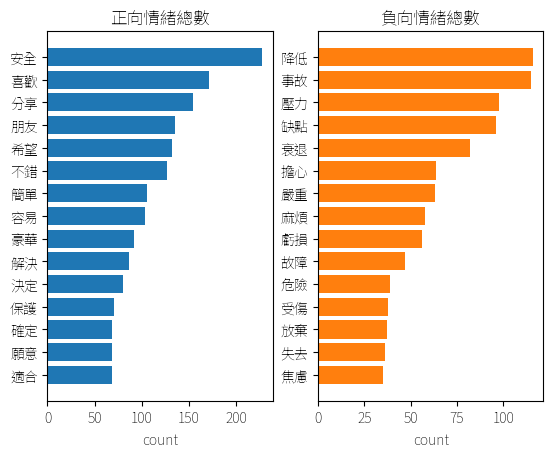

In [100]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

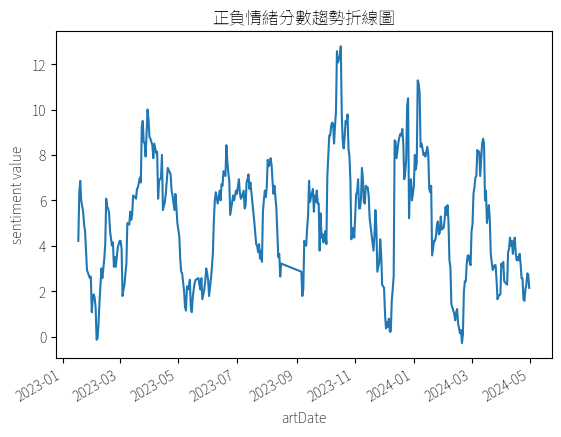

In [101]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

### 3.8 文字雲
如果文字雲中的字詞大小越大，代表出現頻率越高

#### 2023-10-15 ~2023-11-01 文字雲
2023-10-15 ~2023-11-01 在情緒分數趨勢圖上顯示比較低的分數，我們用文字雲來看一下這段時間出現了什麼關鍵字

將前面計算出的文章情緒類別合併，以利我們過濾出負面文章資料

In [102]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦,affect,負向
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦,negative,負向
2,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,官網,NaN,負向
3,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,二手車,NaN,負向
4,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,三方,NaN,負向


In [103]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦是官網特斯拉二手車,負向
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,比很多第三方平台都便宜,負向
2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,各位前輩好 想買中古特斯拉里程約萬上下的,負向
3,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,擔心電池久了會掉電越充越少電 里程數越少開了年後車子變成c垃圾里程連公里都不到,負向
4,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,另外請問電動車建議買新的還是中古的就好因為有載寵物 就算之後賣中古應該也沒人收但是想要負擔輕...,負向


In [104]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
98328,https://www.ptt.cc/bbs/car/M.1697602381.A.2B1....,2023-10-18,Re:[新聞]特斯拉電池遭雨水浸泡！ 「維修費70萬,https://www.mobile01.com/topicdetail.php?f=346...,一下,NaN,負向
98329,https://www.ptt.cc/bbs/car/M.1697602381.A.2B1....,2023-10-18,Re:[新聞]特斯拉電池遭雨水浸泡！ 「維修費70萬,https://www.mobile01.com/topicdetail.php?f=346...,這位,NaN,負向
98330,https://www.ptt.cc/bbs/car/M.1697602381.A.2B1....,2023-10-18,Re:[新聞]特斯拉電池遭雨水浸泡！ 「維修費70萬,https://www.mobile01.com/topicdetail.php?f=346...,ist,NaN,負向
98331,https://www.ptt.cc/bbs/car/M.1697602381.A.2B1....,2023-10-18,Re:[新聞]特斯拉電池遭雨水浸泡！ 「維修費70萬,https://www.mobile01.com/topicdetail.php?f=346...,苦主,NaN,負向
98332,https://www.ptt.cc/bbs/car/M.1697602381.A.2B1....,2023-10-18,Re:[新聞]特斯拉電池遭雨水浸泡！ 「維修費70萬,https://www.mobile01.com/topicdetail.php?f=346...,淹水,NaN,負向
...,...,...,...,...,...,...,...
104788,https://www.ptt.cc/bbs/car/M.1698829693.A.DBF....,2023-11-01,Re:[新聞]特斯拉失控狂飆時速198公里失事致2死3傷,中國法院判決，特斯拉潮州車禍與車輛本身無關\n財訊快報\n2023年11月1日 週三 下午3...,轉發,NaN,負向
104789,https://www.ptt.cc/bbs/car/M.1698829693.A.DBF....,2023-11-01,Re:[新聞]特斯拉失控狂飆時速198公里失事致2死3傷,中國法院判決，特斯拉潮州車禍與車輛本身無關\n財訊快報\n2023年11月1日 週三 下午3...,勝訴,NaN,負向
104790,https://www.ptt.cc/bbs/car/M.1698829693.A.DBF....,2023-11-01,Re:[新聞]特斯拉失控狂飆時速198公里失事致2死3傷,中國法院判決，特斯拉潮州車禍與車輛本身無關\n財訊快報\n2023年11月1日 週三 下午3...,媒體,NaN,負向
104791,https://www.ptt.cc/bbs/car/M.1698829693.A.DBF....,2023-11-01,Re:[新聞]特斯拉失控狂飆時速198公里失事致2死3傷,中國法院判決，特斯拉潮州車禍與車輛本身無關\n財訊快報\n2023年11月1日 週三 下午3...,車板,NaN,負向


In [105]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
805,電動車,27
710,車主,15
190,充電,15
44,Tesla,14
67,iPhone,13
...,...,...
82,remember,1
394,我特,1
395,戰略,1
396,手中,1


(-0.5, 399.5, 199.5, -0.5)

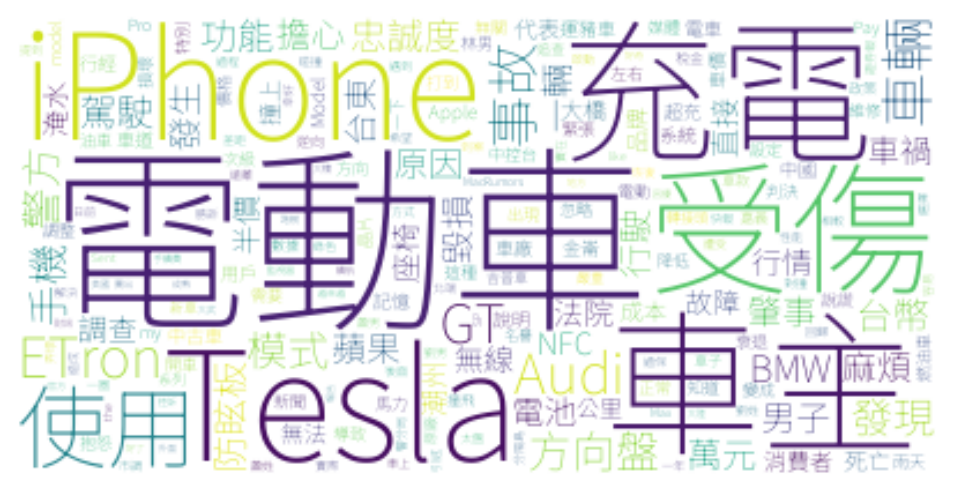

In [106]:
# wordcloud 的 input 是 dictionary
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

關鍵字出現了「iphone」、「特斯拉」、「賣超」、「衝突」、「下跌」的關鍵字，可能是在說明特斯拉充電疑慮。

In [107]:
date = "2023-01-10"
end_date = "2023-05-31"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('美債')) & ( # 內文包含美債
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

利用「下挫」去查看原文內容

In [ ]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('美債')) & (
    sent_df['sentence'].str.contains('下挫')) # 包含「下挫」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
44922,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,引發投資人擔憂聯準會Fed可能將利率維持在高檔更久,負向
44923,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,並可能再度升息,負向
44924,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r同\r時,負向
44925,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r道瓊工業指數早盤跌近百點或,負向
44926,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,標普指數和那斯達克綜合指數各跌和,負向
44927,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r費城半導體指數下挫,負向
44928,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,台積電ADR也跌,負向
44929,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r\r美國月整體零售銷售月增,負向
44930,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,遠高於預估的增幅,負向
44931,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,扣除汽車之後的核心銷售額比\r月增加,負向


文章中提到了台股重挫，道瓊指數下跌